# AM207 Final Project

Paper: *Learned Uncertainty-Aware (LUNA) Bases for Bayesian Regression using Multi-Headed Auxiliary Networks*

207Notes:
 -  reproduce figure 6 (rows are random restarts, see main paper) with NLM 2 hidden layers 50-50
 -  new code: plot the priors
 -  verify in paper, how many iterations were done for this figure, verify data generating process
 - 
 -  

In [2]:
# this code is for an elaine problem:
# import sys
# sys.path.append('/Users/elainecunha/opt/anaconda3/envs/py3.8/lib/python3.8/site-packages')

In [23]:
from autograd import numpy as np
from autograd import grad
from autograd.misc.optimizers import adam, sgd
from autograd import scipy as sp
import autograd.numpy.random as npr
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import sys
import time

# our libraries
import utils
from nlm import NLM
from feed_forward import Feedforward
import bayes_helpers as bh

### Generate Data

In [5]:
number_of_points = 50
x_train, y_train, x_test = utils.generate_data(number_of_points)

#### Define NN Hyperparameters

In [6]:
###relu activation
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)


###neural network model design choices
width = 50
hidden_layers = 2
input_dim = 1
output_dim = 1

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'relu',
               'activation_fn_params': 'rate=1',
               'activation_fn': activation_fn}

#set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

###define design choices in gradient descent
params = {'step_size':1e-3, 
          'max_iteration':10000, 
          'random_restarts':1,
          'optimizer':'adam'}


### Run Vanilla Nueral Network

 Iteration 9900 lower bound 398.268494321817; gradient mag: 425.6834906285177265832.561 Seconds


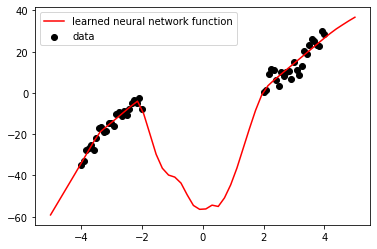

In [10]:
nn = Feedforward(architecture, random=random)

t0 = time.time()
#fit my neural network to minimize MSE on the given data
nn.fit(x_train, y_train, params)
nn_time = np.round(time.time() - t0, 3)

print(f"{nn_time} Seconds")

#predict on the test x-values
y_test_pred = nn.forward(nn.weights, x_test)

#visualize the function learned by the neural network
plt.scatter(x_train.flatten(), y_train.flatten(), color='black', label='data')
plt.plot(x_test.flatten(), y_test_pred.flatten(), color='red', label='learned neural network function')
plt.legend(loc='best')
plt.show()

#utils.run_toy_nn(Feedforward,architecture,params,random,x_train,y_train,x_test)

### NLM Demo

In [19]:
def get_prior_samples(prior_var, prior_mean, x_matrix, samples=100):
    '''Generates prior samples for Bayesian linear regression model coefficients'''
    
    prior_variance = np.diag(prior_var * np.ones(x_matrix.shape[1])) # make it 2 D
    prior_mean = prior_mean*np.ones(x_matrix.shape[1])
    
    # sample weights from prior
    prior_samples = np.random.multivariate_normal(prior_mean, prior_variance, size=samples)
    
    return prior_samples

In [24]:
# create instance of NLM
prior_var = 1.0
y_var = 1.0
regularization_param_nlm = 0
test_nlm = NLM(prior_var,y_var, regularization_param_nlm,architecture, random_state = np.random.RandomState(0))

In [ ]:
# train NLM
params = {'step_size':1e-3, 
          'max_iteration':10000, 
          'random_restarts':1,
          'optimizer':'adam'}

t0 = time.time()
test_nlm.train(x_train,y_train, params)
nlm_time = np.round(time.time() - t0, 3)
print(f"{nlm_time} Seconds")

 Iteration 2800 lower bound 439.8809970374627; gradient mag: 152.922654749641656

In [14]:
# calculate posterior predictive
posterior_predictives, posterior_predictive_samples = test_nlm.predict(x_test)

In [22]:
# calculate prior predictive

# get final layer
final_layer = test_nlm.ff.forward(test_nlm.ff.weights, X, final_layer_out=True)
x_test_matrix = final_layer.T[:,:,0]

# get prior predictive
prior_samples = get_prior_samples(prior_var, 0, x_test_matrix)
prior_predictives, prior_predictive_samples = get_bayes_lr_posterior_predictives(noise_var,prior_samples,x_test_matrix)

NameError: name 'X' is not defined

In [ ]:
bh.viz_pp_samples(x_train, y_train, x_test.flatten(), posterior_predictive_samples, "NLM test")